In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [13]:
def Bayesian_PCA(X, q, num_epochs=100):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    M: The maximum possible dimensionality of the latent space.
    num_epochs: The number of iterations for the EM algorithm.

    Outputs:
    W_MP: The estimated weight matrix with shape (D, M).
    sigma: The estimated noise variance.
    alpha: The estimated hyperparameters.
    """

    # Get the number of data points (N) and the dimensionality of the data (D)
    N, D = X.shape
    
    # Initialize the weight matrix (W_MP), noise variance (sigma), and hyperparameters (alpha)
    W_MP = np.random.randn(D, q)
    sigma = abs(np.random.random())
    alpha = D / np.linalg.norm(W_MP, axis=0)

    # Run the EM algorithm for num_epochs iterations
    for epoch in range(num_epochs):
        # E-step: Compute the expected values of the latent variables
        M_matrix = W_MP.T @ W_MP + sigma * np.eye(q)  #(q,q)
        M_inv=np.linalg.pinv(M_matrix)  #(q,q)

        
        Xn = (M_inv @ W_MP.T @ X.T).T  #(n,q)
        Exn=[]

        for i in range(N):
            Xn_i = Xn[i].reshape(-1,1)
            Exn.append(sigma*M_inv+Xn_i@Xn_i.T)

        Exn=np.array(Exn)

        # M-step: Update the weight matrix, noise variance, and hyperparameters
        W_MP_new=(X.T@Xn)@np.linalg.pinv(Exn.sum(axis=0)+sigma*np.diag(alpha))  #(d,q)

        sigma= 0
        for i in range(N):
            sigma+=X[i] @ X[i].T - 2* Xn[i].T @ W_MP_new.T @ X[i] + np.trace(Exn[i]@W_MP_new.T@W_MP_new)
        sigma/=(N*D)
        alpha = D /(np.linalg.norm(W_MP_new, axis=0)+1e-12)

        # Update the weight matrix
        W_MP = W_MP_new

    return W_MP, sigma, alpha


def project_to_latent_space(X, W_MP, sigma, alpha):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    W_MP: The weight matrix with shape (D, M).
    sigma: The noise variance.
    alpha: The hyperparameters.

    Outputs:
    E_x_n: The expected values of the latent variables.
    """

    # Get the dimensionality of the latent space
    M = len(alpha)

    # Compute the M matrix and its inverse
    M_matrix = np.dot(W_MP.T, W_MP) + sigma * np.eye(M)
    M_matrix_inverse = np.linalg.inv(M_matrix)

    # Compute the expected values of the latent variables
    E_x_n = np.dot(np.dot(X, W_MP), M_matrix_inverse)

    return E_x_n


In [15]:
# Generate synthetic data with given characteristics
np.random.seed(0)
std_devs = np.concatenate([np.ones(3), 0.5*np.ones(7)])  # 1.0 in 3 directions and 0.5 in the remaining 7 directions
cov_matrix = np.diag(std_devs**2)
X = np.random.multivariate_normal(np.zeros(10), cov_matrix, size=300)
W_MP, sigma, alphahan = Bayesian_PCA(X, q=X.shape[1]-1, num_epochs=500)

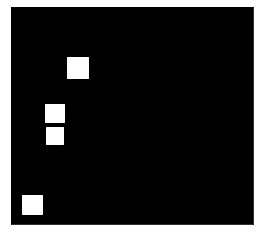

In [16]:
def hinton(matrix, max_weight=None, ax=None, threshold=0.1):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('black')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'black' if np.abs(w) <= threshold else ('black' if w > 0 else 'white')  # Change color to black if magnitude is below threshold
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

# Use the function
hinton(W_MP, threshold=0.4)
plt.show()

100%|██████████| 16/16 [03:13<00:00, 12.12s/it]


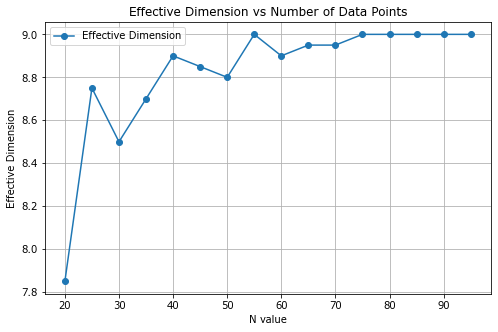

In [18]:
# Generate synthetic data with given characteristics
np.random.seed(0)
std_devs = np.array([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
cov_matrix = np.diag(std_devs**2)

# effective dimensions for different N values 
effective_dimensions = []
nb_iterations = 20

for N in tqdm(range(20, 100, 5)):  # Assuming you want to increase the number of data points from 10 to 200
    effective_dimension_experiments = []
    for _ in range(nb_iterations):  # Perform 50 independent experiments
        X = np.random.multivariate_normal(np.zeros(10), cov_matrix, size=N)
        # Perform Bayesian PCA (you need to implement or import Bayesian_PCA function)
        W_MP, sigma, alpha = Bayesian_PCA(X, q=X.shape[1]-1) 
        # Determine the effective dimension
        effective_dimension = np.sum(alpha < 1e12)
        effective_dimension_experiments.append(effective_dimension)
    # Average the effective dimensions over the 50 experiments
    effective_dimensions.append(np.mean(effective_dimension_experiments))

# Plotting the results similar to Figure in the image 
plt.figure(figsize=(8,5))
plt.plot(range(20, 100, 5), effective_dimensions,'o-', label='Effective Dimension')
plt.xlabel('N value')
plt.ylabel('Effective Dimension')
plt.title('Effective Dimension vs Number of Data Points')
plt.legend()
plt.grid(True)
plt.show()
